In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

import time

tempoInicial = time.time()

In [2]:
def N(n):
    return 1*1./np.sqrt(np.sqrt(np.pi)*2**n*factorial(n))

def psix(n, x):
    Hn=hermite(n)
    Px = N(n)*Hn(x)*np.exp(-0.5*x**2)
    return Px

def psixt(n, x, t):
    Hn=hermite(n)
    a = complex(0,1)
    Pxt = N(n)*Hn(x)*np.exp(-0.5*x**2)*np.exp(-a*(n+1/2)*t*np.pi)
    return Pxt

In [3]:
def CrankNicolson(M, O = 0, L = 1, T = 0.5):
    N = 100 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    P = 3.141111111111111111111111111
    #Discretização espacial
    dx = (xL - x0)/(P*M-1) 

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(P*N-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)

    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    V = 1/2*m*w**2*xs**2

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()
    
    #Obtenção da matriz psi (Ela acumulará para o psi futuro)
    ps = np.zeros((M, N))
    psi_c = np.zeros((M, N))

    #Condição inicial
    ps[:,0] = 0.80 * psix(0, xs) + 0.60 * psix(1, xs) #A primeira coluna da matriz terá a equação inicial, em todas as posições
    psi_c = ps.astype(complex)
    #For para o acúmulo de resultados
    for k in range(1,N):
        b = np.matmul(matrizB, np.array(psi_c[0:M, k-1])) #Multiplicação de arrays já que houve uma conversão anterior
        psi_c[0:M, k] = np.linalg.solve(matrizA, b) #Matlab: x = A\b
        #plt.plot(xs, np.absolute(psi_c[0:M, k])**2)
    return psi_c

In [4]:
def multMatrizes(M, us, O = -5, L = 5, T = 10):
    N = 100 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    P = 3.141111111111111111111111111
    #Discretização espacial
    dx = (xL - x0)/(P*M-1) 

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(P*N-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)
    
    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    #V = us #V(x,u(t))
    V = 1/2*m*w**2*xs**2+us

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()

    return np.matmul(np.linalg.inv(matrizA), matrizB)

In [5]:
# Gradiente e função objetivo

def ExactSolution(M, T = 5, L = 5):
    N = 100

    xs = np.linspace(-5, L, M)
    ts = np.linspace(0, N/10, T)
    
    psiExato = np.zeros((M, N)).astype(complex)
    r=0
    for i in np.arange(-5, 5, 0.1):
        for j in np.arange(0, 10, 0.1):
            psiExato[r][int(j*10)] = 1/np.sqrt(2)*psixt(0,i,j)+1/np.sqrt(2)*psixt(1,i,j)
        r+=1
    return psiExato

def Objetivo(x, y, psi, psiExato):
    A = np.zeros((100,100))
    B = np.zeros((100,100))
    A = multMatrizes(M = 100, us = x[0])
    B = multMatrizes(M = 100, us = x[1])
    return ((np.linalg.norm(np.array(psiExato[0:100, y])-np.array(psi)))**2+
            (np.linalg.norm(np.array(psiExato[0:100, y+1])-np.array(np.matmul(A,psi))))**2+
            (np.linalg.norm(np.array(psiExato[0:100, y+2])-np.array(np.matmul(np.matmul(B,A),psi))))**2)

In [6]:
import random

psi = np.zeros((100,100))
psi_f = np.zeros((100,100))
psi_g = psi_f.astype(complex)
psi = CrankNicolson(M = 100, O = -5, L = 5, T = 10)
psiExato = ExactSolution(M = 100)

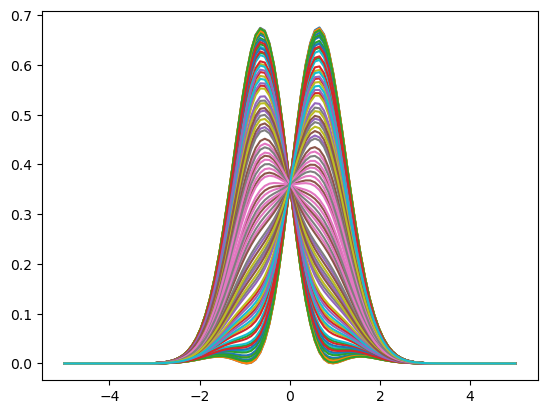

In [7]:
xs = np.linspace(-5,5,100)
plt.plot(xs, np.absolute(psi[0:100,0:100])**2)

[1.5145725157348817, 1.0225624322569091]
Iteração: 1
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 5587.2883677158225
       x: [-1.593e+02  7.489e+00]
     nit: 13
     jac: [ 0.000e+00  0.000e+00]
    nfev: 129
    njev: 43
---------------
[-159.29089240748235, 2.7690634706942685]
Iteração: 2
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 4973.894737845405
       x: [ 7.489e+00  7.175e+00]
     nit: 16
     jac: [ 0.000e+00  0.000e+00]
    nfev: 153
    njev: 51
---------------
[7.489172153779462, -3.6113682117714427]
Iteração: 3
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 4918.7270320765965
       x: [ 7.175e+00  6.990e+00]
     nit: 10
     jac: [ 0.000e+00  0.000e+00]
    nfev: 75
    njev: 25
---------------
[7.1746313029024416, 4.725277235854945]
Iteração: 4
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 4884.766705519567
   

Iteração: 30
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 5137.68652145974
       x: [ 8.003e+00  8.821e+00]
     nit: 7
     jac: [ 0.000e+00  0.000e+00]
    nfev: 63
    njev: 21
---------------
[8.002993683173367, 4.417583921490616]
Iteração: 31
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 5237.849681746366
       x: [ 8.821e+00  1.014e+01]
     nit: 5
     jac: [ 0.000e+00  0.000e+00]
    nfev: 57
    njev: 19
---------------
[8.821031111917273, 1.0587481476541551]
Iteração: 32
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 5340.8766353147075
       x: [ 1.014e+01  1.226e+01]
     nit: 15
     jac: [ 0.000e+00  0.000e+00]
    nfev: 129
    njev: 43
---------------
[10.143628840722302, -0.8769492380197255]
Iteração: 33
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 5434.930210268729
       x: [ 1.226e+01  1.530e+01]
     nit: 11


Iteração: 60
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 5137.686780562701
       x: [ 8.821e+00  8.003e+00]
     nit: 11
     jac: [ 0.000e+00  0.000e+00]
    nfev: 78
    njev: 26
---------------
[8.821288172925383, 4.973943481212325]
Iteração: 61
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 5048.02014938486
       x: [ 8.003e+00  7.492e+00]
     nit: 11
     jac: [ 0.000e+00  0.000e+00]
    nfev: 66
    njev: 22
---------------
[8.00276516007156, 4.596797992027625]
Iteração: 62
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 4973.894734643714
       x: [ 7.492e+00  7.174e+00]
     nit: 6
     jac: [ 0.000e+00  0.000e+00]
    nfev: 27
    njev: 9
---------------
[7.491529238345582, -3.299477072127708]
Iteração: 63
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 4918.7270315352835
       x: [ 7.175e+00  6.990e+00]
     nit: 11
     

Iteração: 90
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 5137.6865249637685
       x: [ 8.003e+00  8.821e+00]
     nit: 9
     jac: [ 0.000e+00  6.104e-05]
    nfev: 186
    njev: 58
---------------
[8.003228202056377, -3.643971172866488]
Iteração: 91
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 5237.849684716994
       x: [ 8.821e+00  1.014e+01]
     nit: 9
     jac: [ 0.000e+00  0.000e+00]
    nfev: 66
    njev: 22
---------------
[8.820888650528902, 3.121566082407641]
Iteração: 92
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 5340.876636976951
       x: [ 1.014e+01  1.226e+01]
     nit: 10
     jac: [ 0.000e+00  0.000e+00]
    nfev: 87
    njev: 29
---------------
[10.14360688672068, -3.671169938628611]
Iteração: 93
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 5434.930210119621
       x: [ 1.226e+01  

NameError: name 'tempoIncial' is not defined

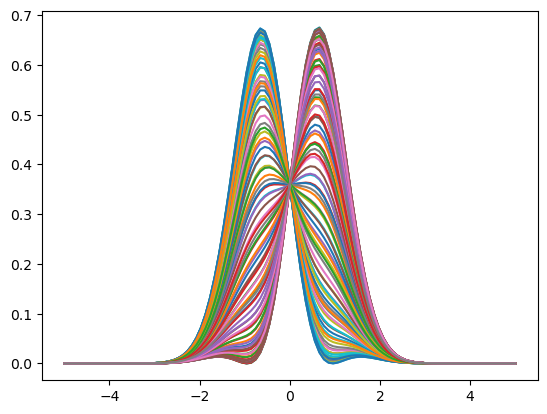

In [8]:
u1 = []
u2 = []
vetor = []
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
tempo = 0
xs = np.linspace(-5,5,100)
minimo = np.zeros((1, 100)).astype(complex)

while tempo < 98:
    print(u1)
    psi_g[0:100, tempo] = psi[0:100, tempo]
    plt.plot(xs, np.absolute(psi[0:100, tempo])**2)
    u2 = optimize.minimize(Objetivo, u1, args=(tempo, psi, psiExato), method='CG')
    print(f"Iteração: {tempo+1}")
    print(u2)
    print("---------------")
    minimo[0][tempo] = (u2.x[0])
    D = multMatrizes(M = 100, us = u2.x[0])
    psi = np.matmul(D, psi)
    tempo += 1
    u1 = []
    u1.append(u2.x[0])
    u1.append(random.uniform(-5, 5))

tempoFinal = time.time() - tempoIncial
print(tempoFinal)

In [ ]:
from matplotlib import animation
from matplotlib.animation import PillowWriter

def animate(i):
    xs = np.linspace(-5,5,100)
    ln1.set_data(xs, np.absolute(psi_g[0:100,i-1])**2)
    ln2.set_data(xs, np.absolute(psiExato[0:100,i-1])**2)
    time_text.set_text('$t=$'+'{:.1f}'.format(i/100))
    
fig, ax = plt.subplots(1, 1,figsize=(8,4))
ax.grid()
ln1, = plt.plot([], [], 'r-', lw=2, markersize=8, label='Origem')
ln2, = plt.plot([], [], 'b-', lw=2, markersize=8, label='Destino')
time_text = ax.text(0.85, 0.9, '', fontsize=15,
           bbox=dict(facecolor='white', edgecolor='black'))
ax.set_ylim(0, 1)
ax.set_xlim(-5,5)
title = ax.set_title('Resposta analítica')
ax.set_ylabel('$|\psi(x)|^2$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.legend(loc='upper left')
ax.set_title('')
plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames=100, interval=200)
ani.save('100x100.gif',writer='pillow',fps=10,dpi=100)